# Random Forest

## Импорт

In [1]:
import warnings


from category_encoders.target_encoder import TargetEncoder

from imblearn.over_sampling import SMOTE

from imblearn.pipeline import Pipeline

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

from pandas.plotting import scatter_matrix

import seaborn as sns

from scipy.stats import (percentileofscore,
                         randint,
                         ttest_ind,
                         uniform,
                        )

from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA

from sklearn.dummy import DummyClassifier

from sklearn.ensemble import (GradientBoostingClassifier, 
                              RandomForestClassifier,
                              VotingClassifier,
                             )

from sklearn.feature_selection import (mutual_info_classif, 
                                       RFE,
                                       RFECV,
                                       SelectKBest,
                                      )

from sklearn.impute import (MissingIndicator, 
                            SimpleImputer,
                           )

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (accuracy_score,
                             f1_score,
                             get_scorer, 
                             roc_curve,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                            )

from sklearn.model_selection import (cross_val_predict, 
                                     cross_val_score,
                                     GridSearchCV,
                                     train_test_split,
                                    )

from sklearn.preprocessing import (Binarizer, 
                                   FunctionTransformer, 
                                   KBinsDiscretizer, 
                                   StandardScaler,
                                  )

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier

from xgboost import (plot_importance, 
                     XGBClassifier
                    )


from infographics import *


warnings.simplefilter(action='ignore', category=FutureWarning)


SEED = 42
CV = 5


%matplotlib inline

## Загрузка данных

In [2]:
data = pd.read_csv('../datasets/train.csv')

## Разделения на тестовый и тренировочный наборы

In [3]:
X = data.drop(columns = 'Survived')
y = data.Survived.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

## Обработка данных

### Разработка новых признаков

#### `Title`

In [4]:
def add_title(X, y=None):
    title = X.Name.str.extract(pat=r'\b,\s(.+?)\.\s[\b(]?')
    title = pd.Series(title[0], name='Title').str.lower()
    
    title = title.where(title.isin(['mr', 'miss', 'mrs', 'master']), 'aristocratic')
    
    return pd.concat([X, title], axis='columns')

TitleAdder = FunctionTransformer(func=add_title)

#### `AgeGroup` и `FareGroup`

```Python
Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('discretizer', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')),
    ('encoder', TargetEncoder(cols=[0, 1])),
])
```

#### `Family`

In [5]:
def add_family(X, y=None):
    family = X.Parch + X.SibSp
    family.name ='Family'

    return pd.concat([X, family], axis='columns')

FamilyAdder = FunctionTransformer(func=add_family)

#### `isFramily`
Для добавления атрибута `isFramily` будем использовать `sklearn.preprocessing.Binarizer`.

#### `Cabin`

In [6]:
def encode_cabin(X, y=None):
    data = X.copy()
    data.Cabin = data.Cabin.str.slice(stop=1)
    data.loc[data.Cabin.isna(), 'Cabin'] = 'unknown'
    
    return data

CabinEncoder = FunctionTransformer(func=encode_cabin)

#### `Ticket`

In [7]:
def encode_ticket(X, y=None):
    data = X.copy()
    counts = data.Ticket.value_counts()
    data.Ticket = data.Ticket.replace(counts)
    
    data.loc[data.Ticket.isna(), 'Ticket'] = -1
    
    return data

TicketEncoder = FunctionTransformer(func=encode_ticket)

### Оценка информативности признаков

#### Конвейер
Создадим конвейер, выполняющий обработку данных.

In [8]:
data_prep_target_enc = Pipeline([
    ('title_adder', TitleAdder),
    ('family_adder', FamilyAdder),
    ('cabin_encoder', CabinEncoder),
    ('ticket_encoder', TicketEncoder),
    
    ('col_selector', ColumnTransformer([
        ('drop', 'drop', ['PassengerId', 'Name']),
        ('is_family', Binarizer(), ['Family']),
        ('cat_features', 
         Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                   ('encoder', TargetEncoder()),
                  ]), 
         ['Pclass', 'Sex', 'Embarked', 'Title', 'Cabin', 'Ticket']
        ),
        ('age_fare', 
         Pipeline([
             ('imputer', SimpleImputer(strategy='median')),
             ('discretizer', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')),
             ('encoder', TargetEncoder(cols=[0, 1])),
         ]), 
         ['Age', 'Fare']
        ),
        ('num_features', 
         Pipeline([
             ('imputer', SimpleImputer(strategy='median')),
             ('scaler', StandardScaler()),
         ]), 
         ['SibSp', 'Parch', 'Family']
        ),
    ], remainder='passthrough')
    ),        
])

Попробуем обработать с помощью разработанного конвейера обучающую выборку, преобразовать результат в датафрейм и вывести его первые 5 строк.

In [9]:
cols = [
    'isFamily',
    'Pclass', 
    'Sex', 
    'Embarked', 
    'Title', 
    'Cabin', 
    'Ticket',
    'AgeGroup', 
    'FareGroup', 
    'SibSp', 
    'Parch',
    'Family'
]

preprocessed_data = pd.DataFrame(data_prep_target_enc.fit_transform(X_train, y_train), columns=cols)
preprocessed_data.head()

,isFamily,Pclass,Sex,Embarked,Title,Cabin,Ticket,AgeGroup,FareGroup,SibSp,Parch,Family
0,0.0,0.242967,0.185185,0.330116,0.152913,0.291667,0.416666,0.358025,0.603352,-0.465084,-0.466183,-0.556339
1,0.0,0.446667,0.185185,0.330116,0.152913,0.291667,0.317227,0.358025,0.236486,-0.465084,-0.466183,-0.556339
2,0.0,0.649123,0.185185,0.330116,0.152913,0.682927,0.317227,0.358025,0.603352,-0.465084,-0.466183,-0.556339
3,1.0,0.242967,0.743083,0.330116,0.785047,0.291667,0.317227,0.426829,0.252427,-0.465084,0.727782,0.073412
4,1.0,0.446667,0.743083,0.330116,0.785047,0.291667,0.623188,0.358025,0.435754,0.478335,0.727782,0.703162


#### Корреляция между обучающими признаками

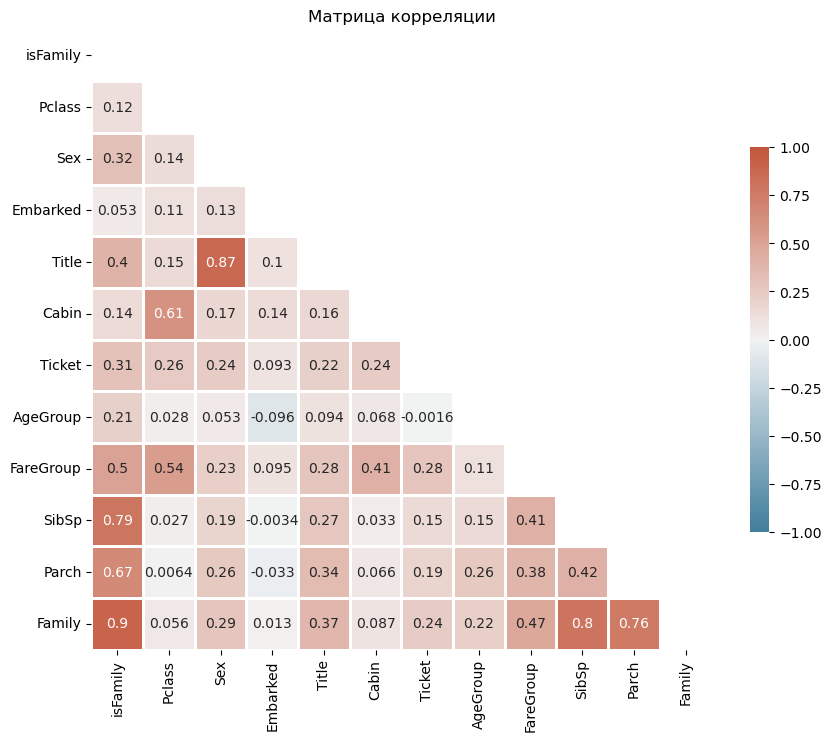

In [10]:
plot_corr_matrix(preprocessed_data, vmin=-1, vmax=1, size=(10, 10), method='kendall')

#### Взаимная информация (Mutual Information)

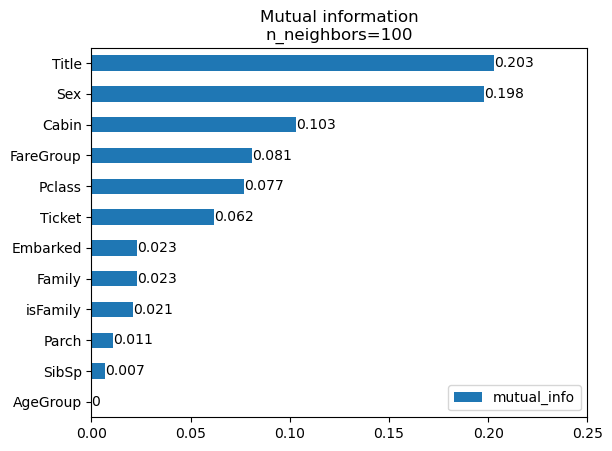

In [11]:
print_mi_scores(preprocessed_data, y_train, 100, random_state=SEED);

## Базовая модель

Значения метрик для DummyClassifier


,mean,median,min,max,results_on_train_set
accuracy,0.519600,0.507042,0.478873,0.601399,0.523876
f1,0.392024,0.414414,0.274510,0.473684,0.399274
roc_auc,0.493290,0.497685,0.446708,0.536827,0.519233


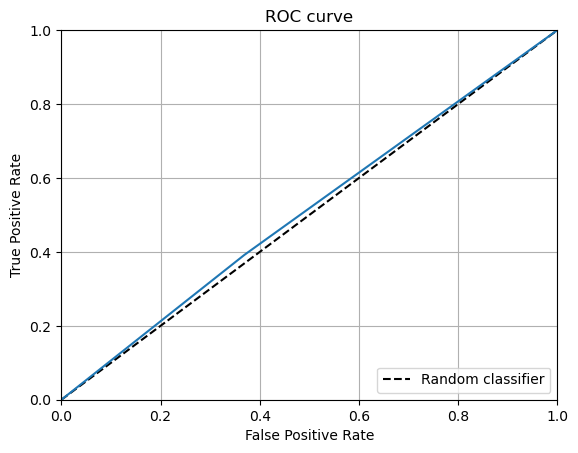

In [12]:
dummy_clf = DummyClassifier(strategy='stratified')

_ = evaluate_model(model=dummy_clf, X=X_train, y=y_train, label='DummyClassifier')

## Bagging

In [13]:
svc = SVC(C=1.5526315789473684, 
          class_weight=None, 
          gamma='scale', 
          kernel='rbf',
          probability=True,
         )

rf = RandomForestClassifier(max_depth=13, 
                            min_samples_split=47, 
                            n_estimators=46,
                           )

xgb = XGBClassifier(colsample_bytree=0.5,
                    learning_rate=1e-05,
                    max_depth=6,
                    n_estimators=28
                   )

voting_clf = VotingClassifier(estimators=[('svc', svc), ('random_forest', rf),('xgb', xgb)], voting='soft', weights=[1, 1, 1])


pipe = Pipeline([
    ('title_adder', TitleAdder),
    ('family_adder', FamilyAdder),
    ('cabin_encoder', CabinEncoder),
    ('ticket_encoder', TicketEncoder),
    
    ('col_selector', ColumnTransformer([
        ('drop', 'drop', ['PassengerId', 'Name']),
        ('is_family', Binarizer(), ['Family']),
        ('cat_features', 
         Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                   ('encoder', TargetEncoder()),
                  ]), 
         ['Pclass', 'Sex', 'Embarked', 'Title', 'Cabin', 'Ticket']
        ),
        ('age_fare', 
         Pipeline([
             ('imputer', SimpleImputer(strategy='median')),
             ('discretizer', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')),
             ('encoder', TargetEncoder(cols=[0, 1])),
         ]), 
         ['Age', 'Fare']
        ),
        ('num_features', 
         Pipeline([
             ('imputer', SimpleImputer(strategy='median')),
             ('scaler', StandardScaler()),
         ]), 
         ['SibSp', 'Parch', 'Family']
        ),
    ], remainder='passthrough')
    ),
    
    ('classifier', voting_clf)
])

pipe

Pipeline(steps=[('title_adder',
                 FunctionTransformer(func=<function add_title at 0x0000025DEB7BE5F0>)),
                ('family_adder',
                 FunctionTransformer(func=<function add_family at 0x0000025DEB7BE9E0>)),
                ('cabin_encoder',
                 FunctionTransformer(func=<function encode_cabin at 0x0000025DEB7BEDD0>)),
                ('ticket_encoder',
                 FunctionTransformer(func=<function encode_ticket at 0x0000025DEB7B...
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=1e-05,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=6,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=28,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             predictor=None,
                                                             random_state=None, ...))],
                                  voting='soft', weights=[1, 1, 1]))])

final pipline
Значения метрик для final pipline


,mean,median,min,max,results_on_train_set
accuracy,0.811839,0.816901,0.790210,0.823944,0.831461
f1,0.739336,0.750000,0.680851,0.777778,0.770713
roc_auc,0.861158,0.861674,0.838326,0.878683,0.895988


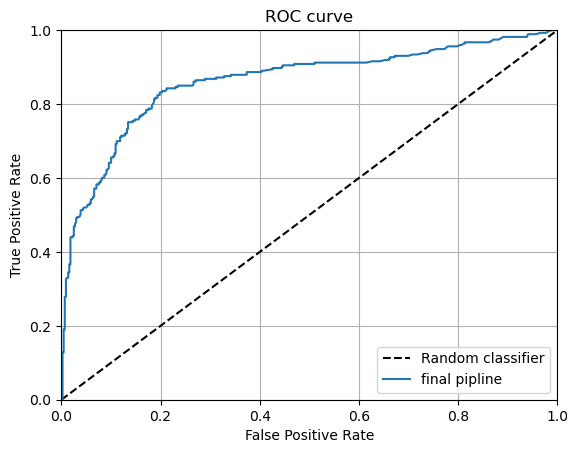

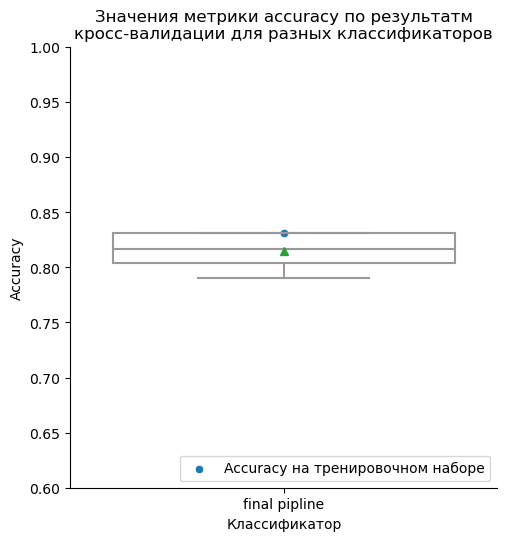

In [14]:
get_performance_of_one_model(model=pipe, 
                             X=X_train,
                             y=y_train, 
                             label='final pipline', 
                             scoring='accuracy', 
                             cv=CV, 
                             n_jobs=-1, 
                             method='predict_proba'
                            )

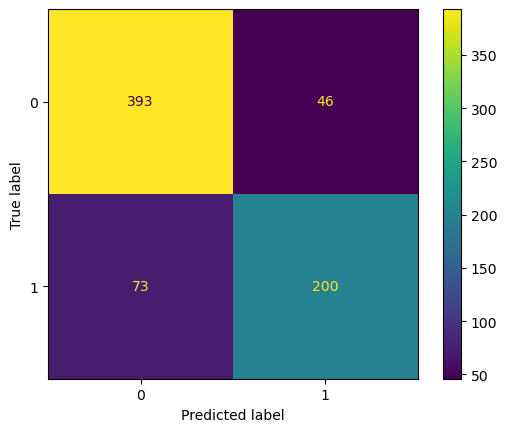

In [15]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, pipe.predict(X_train)),
                              display_labels=pipe.classes_
                             )
disp.plot()
plt.show()

In [16]:
preds = cross_val_predict(estimator=pipe,
                          X=X_train,
                          y=y_train,
                          cv=CV,
                          n_jobs=-1
                         )

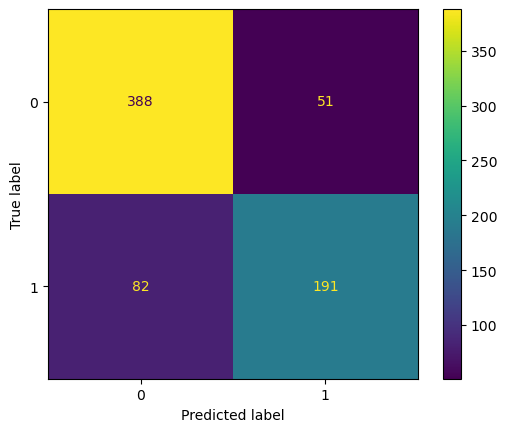

In [17]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, preds),
                              display_labels=pipe.classes_
                             )
disp.plot()
plt.show()

In [18]:
pipe.fit(X, y)

Pipeline(steps=[('title_adder',
                 FunctionTransformer(func=<function add_title at 0x0000025DEB7BE5F0>)),
                ('family_adder',
                 FunctionTransformer(func=<function add_family at 0x0000025DEB7BE9E0>)),
                ('cabin_encoder',
                 FunctionTransformer(func=<function encode_cabin at 0x0000025DEB7BEDD0>)),
                ('ticket_encoder',
                 FunctionTransformer(func=<function encode_ticket at 0x0000025DEB7B...
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=1e-05,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=6,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=28,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             predictor=None,
                                                             random_state=None, ...))],
                                  voting='soft', weights=[1, 1, 1]))])

In [19]:
submission_X = pd.read_csv('../datasets/test.csv')
submission_X.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [20]:
submission_y = pipe.predict(submission_X)


submission = pd.DataFrame({'PassengerId': submission_X.PassengerId,
                           'Survived': submission_y,
                          }
                         )

submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [21]:
submission.to_csv('submission.csv', index=False)